In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.__version__

'0.12.0'

In [3]:
pd.__version__

'1.3.4'

In [14]:
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Human", "Non-Human"]

In [15]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        df["orig_y_pred"] = orig_pred_class
        df["new_y_pred"] = df[classes].idxmax(axis=1)
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [16]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [17]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [18]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2978369, 11)



#### WIV04 reference sequence

In [22]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [79]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [80]:
wiv04_aligned_seq[:1367]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [25]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [26]:
perturbed_output_df

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.988160,0.011840,UniRef90_A0A8B6RAI1,Human,X,768,N,0.000013,0.000013,Human,Human,306
1,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,I,1718,B,0.000000,0.000000,Human,Human,712
2,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,R,1622,T,0.000000,0.000000,Human,Human,634
3,0.988334,0.011666,UniRef90_A0A8B6RAI1,Human,X,127,I,0.000186,0.000186,Human,Human,62
4,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,A,1691,H,0.000000,0.000000,Human,Human,694
...,...,...,...,...,...,...,...,...,...,...,...,...
31596,0.988745,0.011255,UniRef90_A0A8B1JFM7,Human,F,1311,K,0.000018,0.000018,Human,Human,490
31597,0.988728,0.011272,UniRef90_A0A8B1JFM7,Human,T,1754,W,0.000000,0.000000,Human,Human,747
31598,0.988649,0.011351,UniRef90_A0A8B1JFM7,Human,V,273,M,-0.000079,0.000079,Human,Human,130
31599,0.988728,0.011272,UniRef90_A0A8B1JFM7,Human,X,2209,F,0.000000,0.000000,Human,Human,1128


In [27]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [28]:
perturbed_output_df

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.988160,0.011840,UniRef90_A0A8B6RAI1,Human,X,768,N,0.000013,0.000013,Human,Human,306
1,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,I,1718,B,0.000000,0.000000,Human,Human,712
2,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,R,1622,T,0.000000,0.000000,Human,Human,634
3,0.988334,0.011666,UniRef90_A0A8B6RAI1,Human,X,127,I,0.000186,0.000186,Human,Human,62
4,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,A,1691,H,0.000000,0.000000,Human,Human,694
...,...,...,...,...,...,...,...,...,...,...,...,...
31596,0.988745,0.011255,UniRef90_A0A8B1JFM7,Human,F,1311,K,0.000018,0.000018,Human,Human,490
31597,0.988728,0.011272,UniRef90_A0A8B1JFM7,Human,T,1754,W,0.000000,0.000000,Human,Human,747
31598,0.988649,0.011351,UniRef90_A0A8B1JFM7,Human,V,273,M,-0.000079,0.000079,Human,Human,130
31599,0.988728,0.011272,UniRef90_A0A8B1JFM7,Human,X,2209,F,0.000000,0.000000,Human,Human,1128


# Overview

### Distribution of Human class difference

In [29]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [30]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 301 (0.010193303642937716)
Distribution of full perturbation output
n=2952919
       start       end    count  percentage
0  -0.720684 -0.683159        4    0.000135
1  -0.683159 -0.645633        2    0.000068
2  -0.645633 -0.608108        5    0.000169
3  -0.608108 -0.570583        8    0.000271
4  -0.570583 -0.533057       11    0.000373
5  -0.533057 -0.495532        8    0.000271
6  -0.495532 -0.458006        6    0.000203
7  -0.458006 -0.420481       12    0.000406
8  -0.420481 -0.382956       23    0.000779
9  -0.382956 -0.345430       18    0.000610
10 -0.345430 -0.307905       18    0.000610
11 -0.307905 -0.270380       53    0.001795
12 -0.270380 -0.232854       37    0.001253
13 -0.232854 -0.195329       22    0.000745
14 -0.195329 -0.157803       39    0.001321
15 -0.157803 -0.120278       17    0.000576
16 -0.120278 -0.082753       36    0.001219
17 -0.082753 -0.045227       98    0.003319
18 -0.045227 -0.007702     2161  

<Figure size 432x288 with 0 Axes>

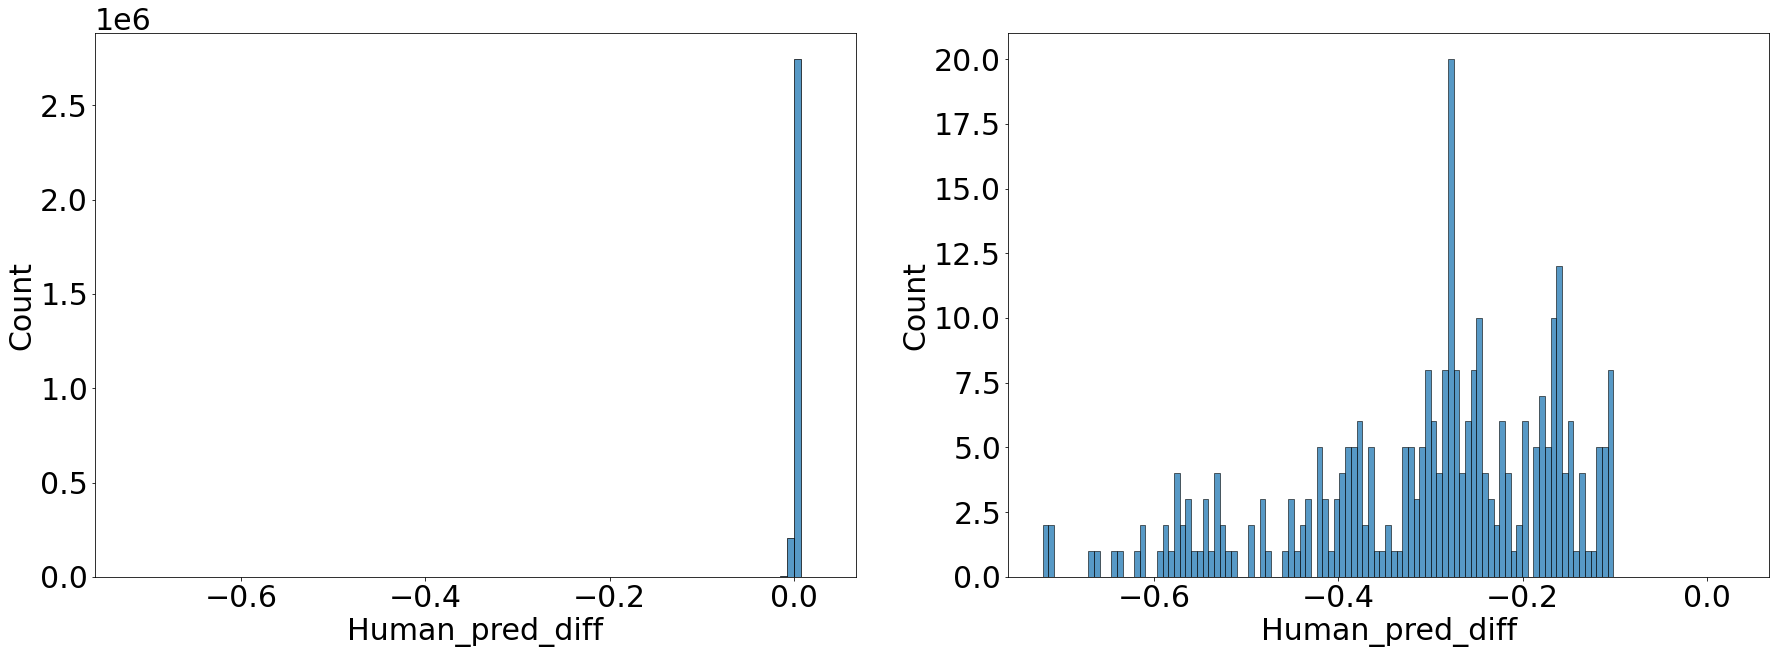

In [31]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

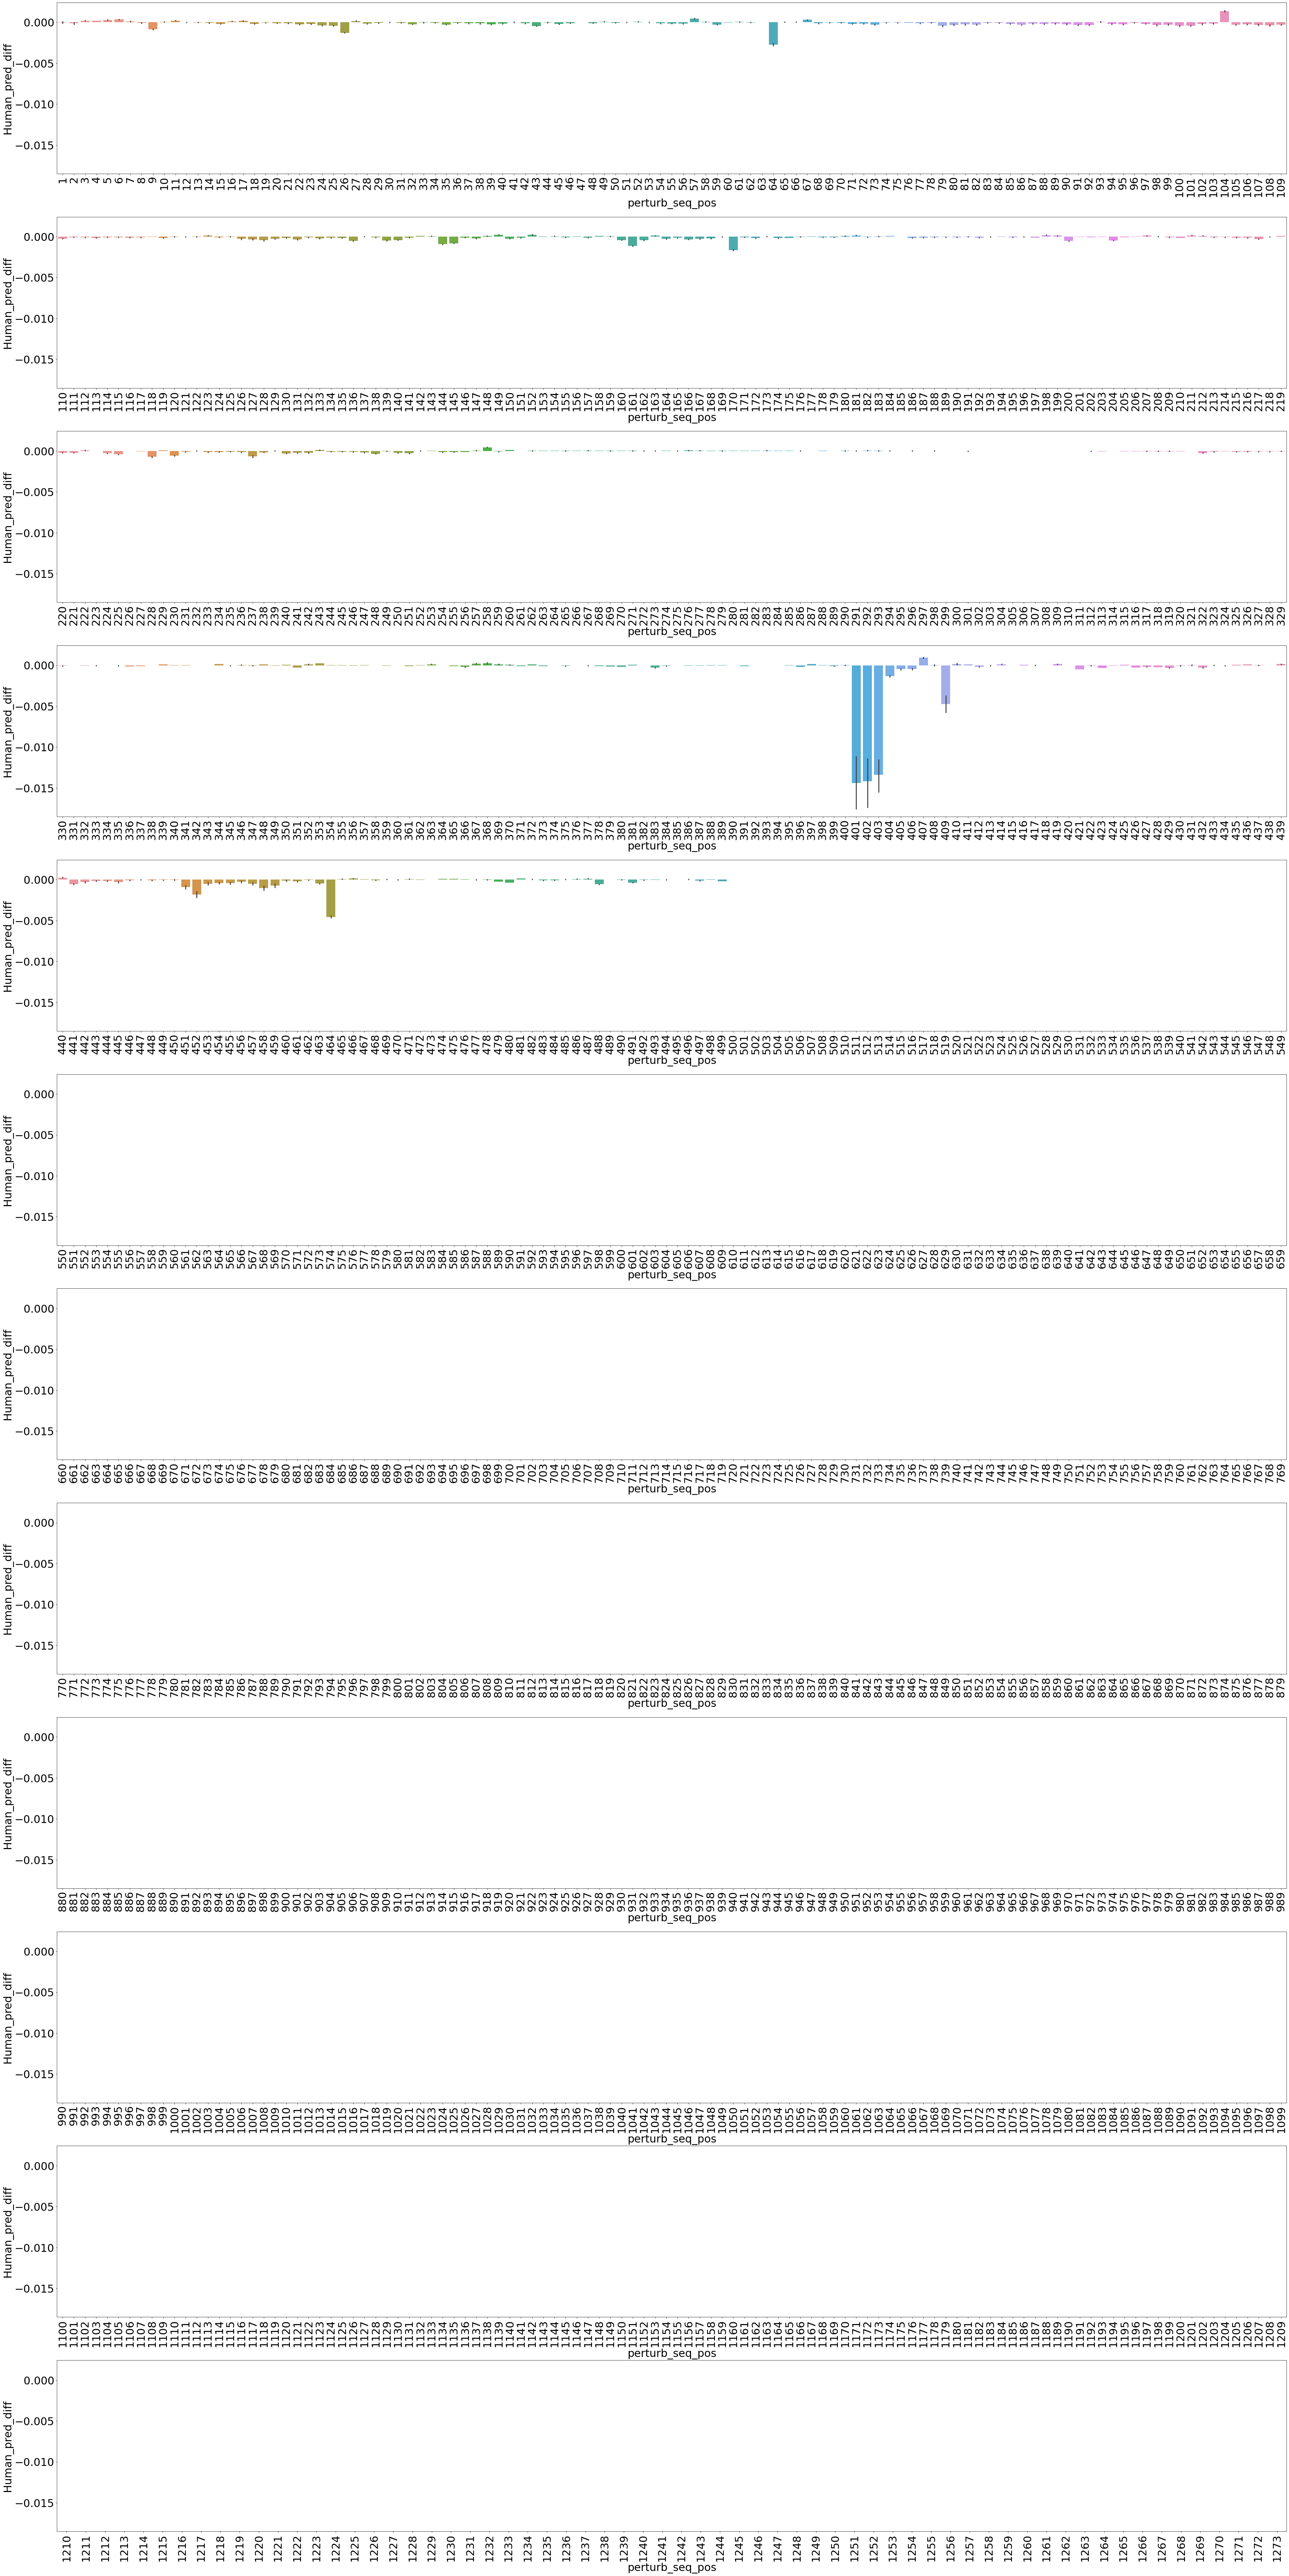

In [32]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

In [33]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
31824,0.991186,0.008814,UniRef90_A0A7T6Y5W2,Human,Y,1624,C,-1.000000e-07,1.000000e-07,Human,Human,636
31825,0.991186,0.008814,UniRef90_A0A7T6Y5W2,Human,G,1505,Y,-1.000000e-07,1.000000e-07,Human,Human,548
31824,0.983690,0.016310,UniRef90_A0A7U3EEK0,Human,H,2156,B,-1.400000e-07,1.400000e-07,Human,Human,1083
30768,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,C,2385,Z,-1.400000e-07,1.400000e-07,Human,Human,1254
30769,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,Y,1748,R,-1.400000e-07,1.400000e-07,Human,Human,741
30770,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,L,2064,Q,-1.400000e-07,1.400000e-07,Human,Human,1001
30771,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,I,2034,L,-1.400000e-07,1.400000e-07,Human,Human,973
30773,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,D,1878,R,-1.400000e-07,1.400000e-07,Human,Human,839
30774,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,L,1592,M,-1.400000e-07,1.400000e-07,Human,Human,611
30775,0.984758,0.015242,UniRef90_A0A8B6RKL0,Human,X,1705,J,-1.400000e-07,1.400000e-07,Human,Human,708


### Cut-off: mean=0 and variance=0

In [34]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

510

<Figure size 432x288 with 0 Axes>

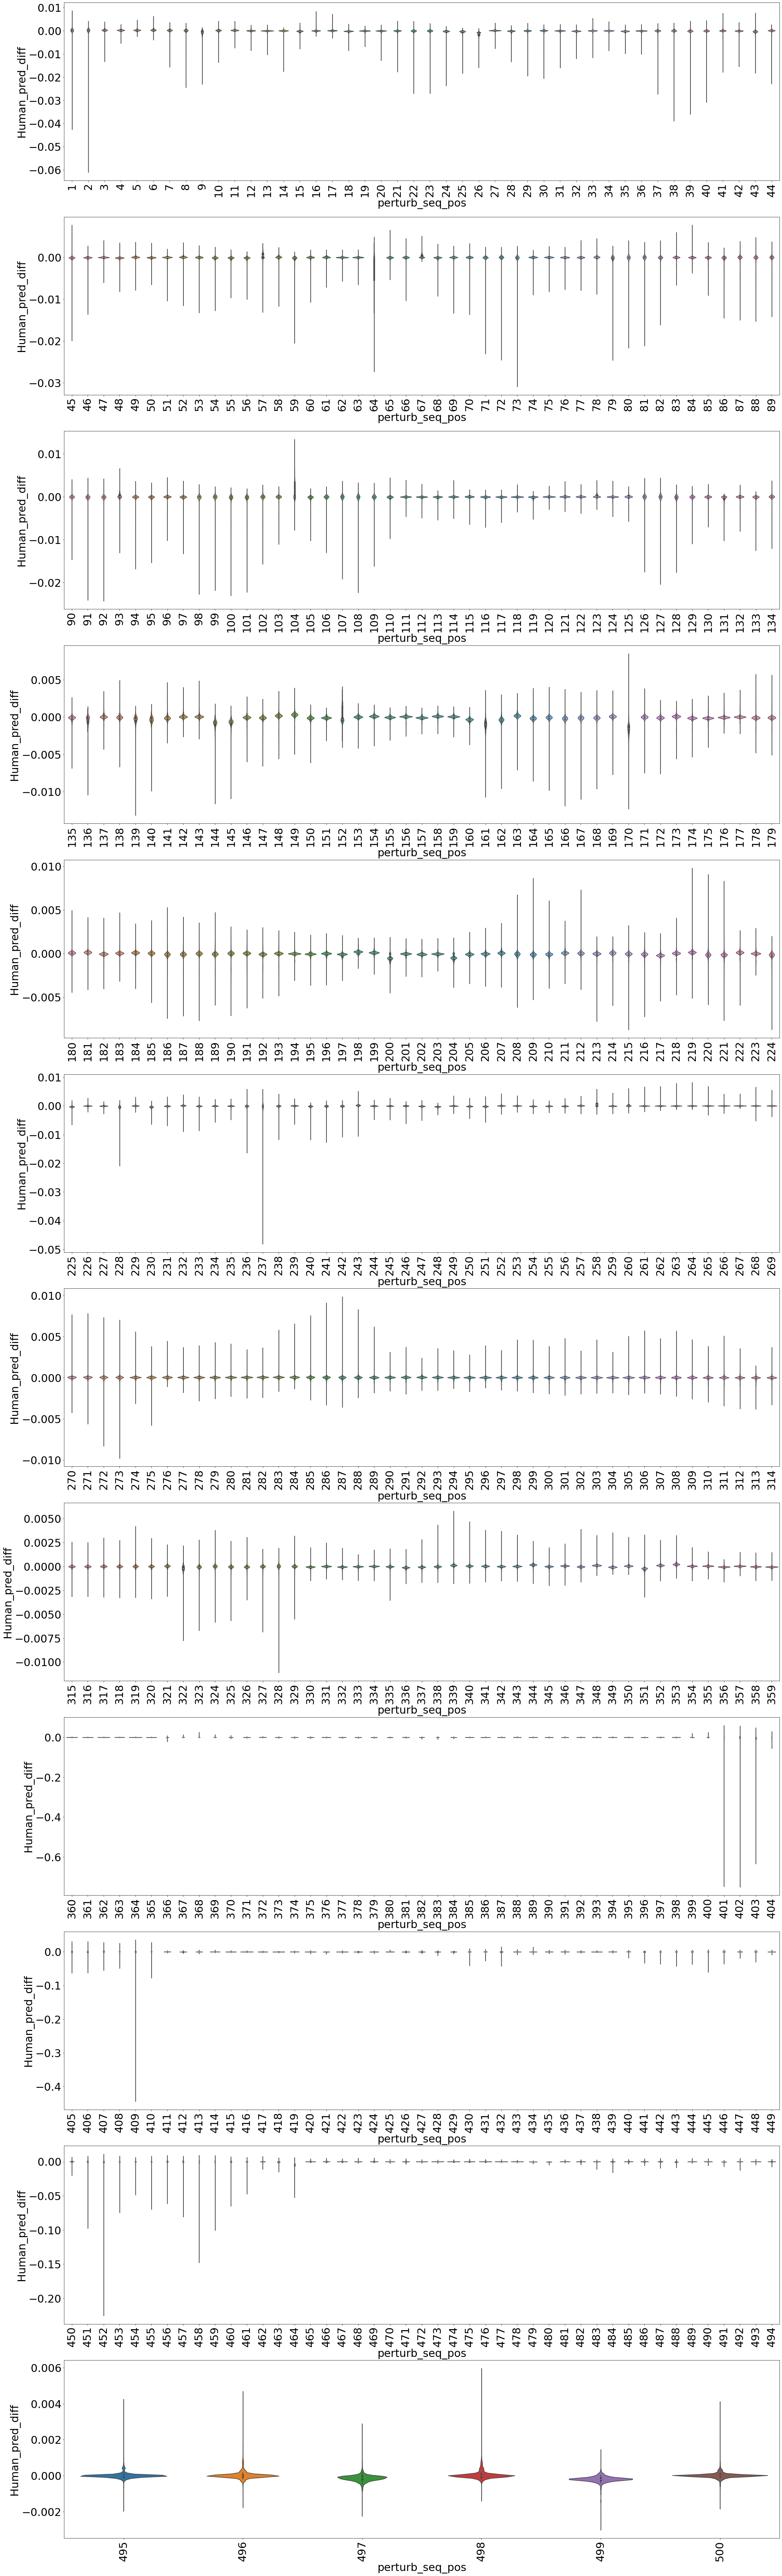

In [37]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 510, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [38]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 510
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 6
1 intersection 2: 6
1 minus 2: 504
2 minus 1: 0
is 2 subset of 1: True


<Figure size 432x288 with 0 Axes>

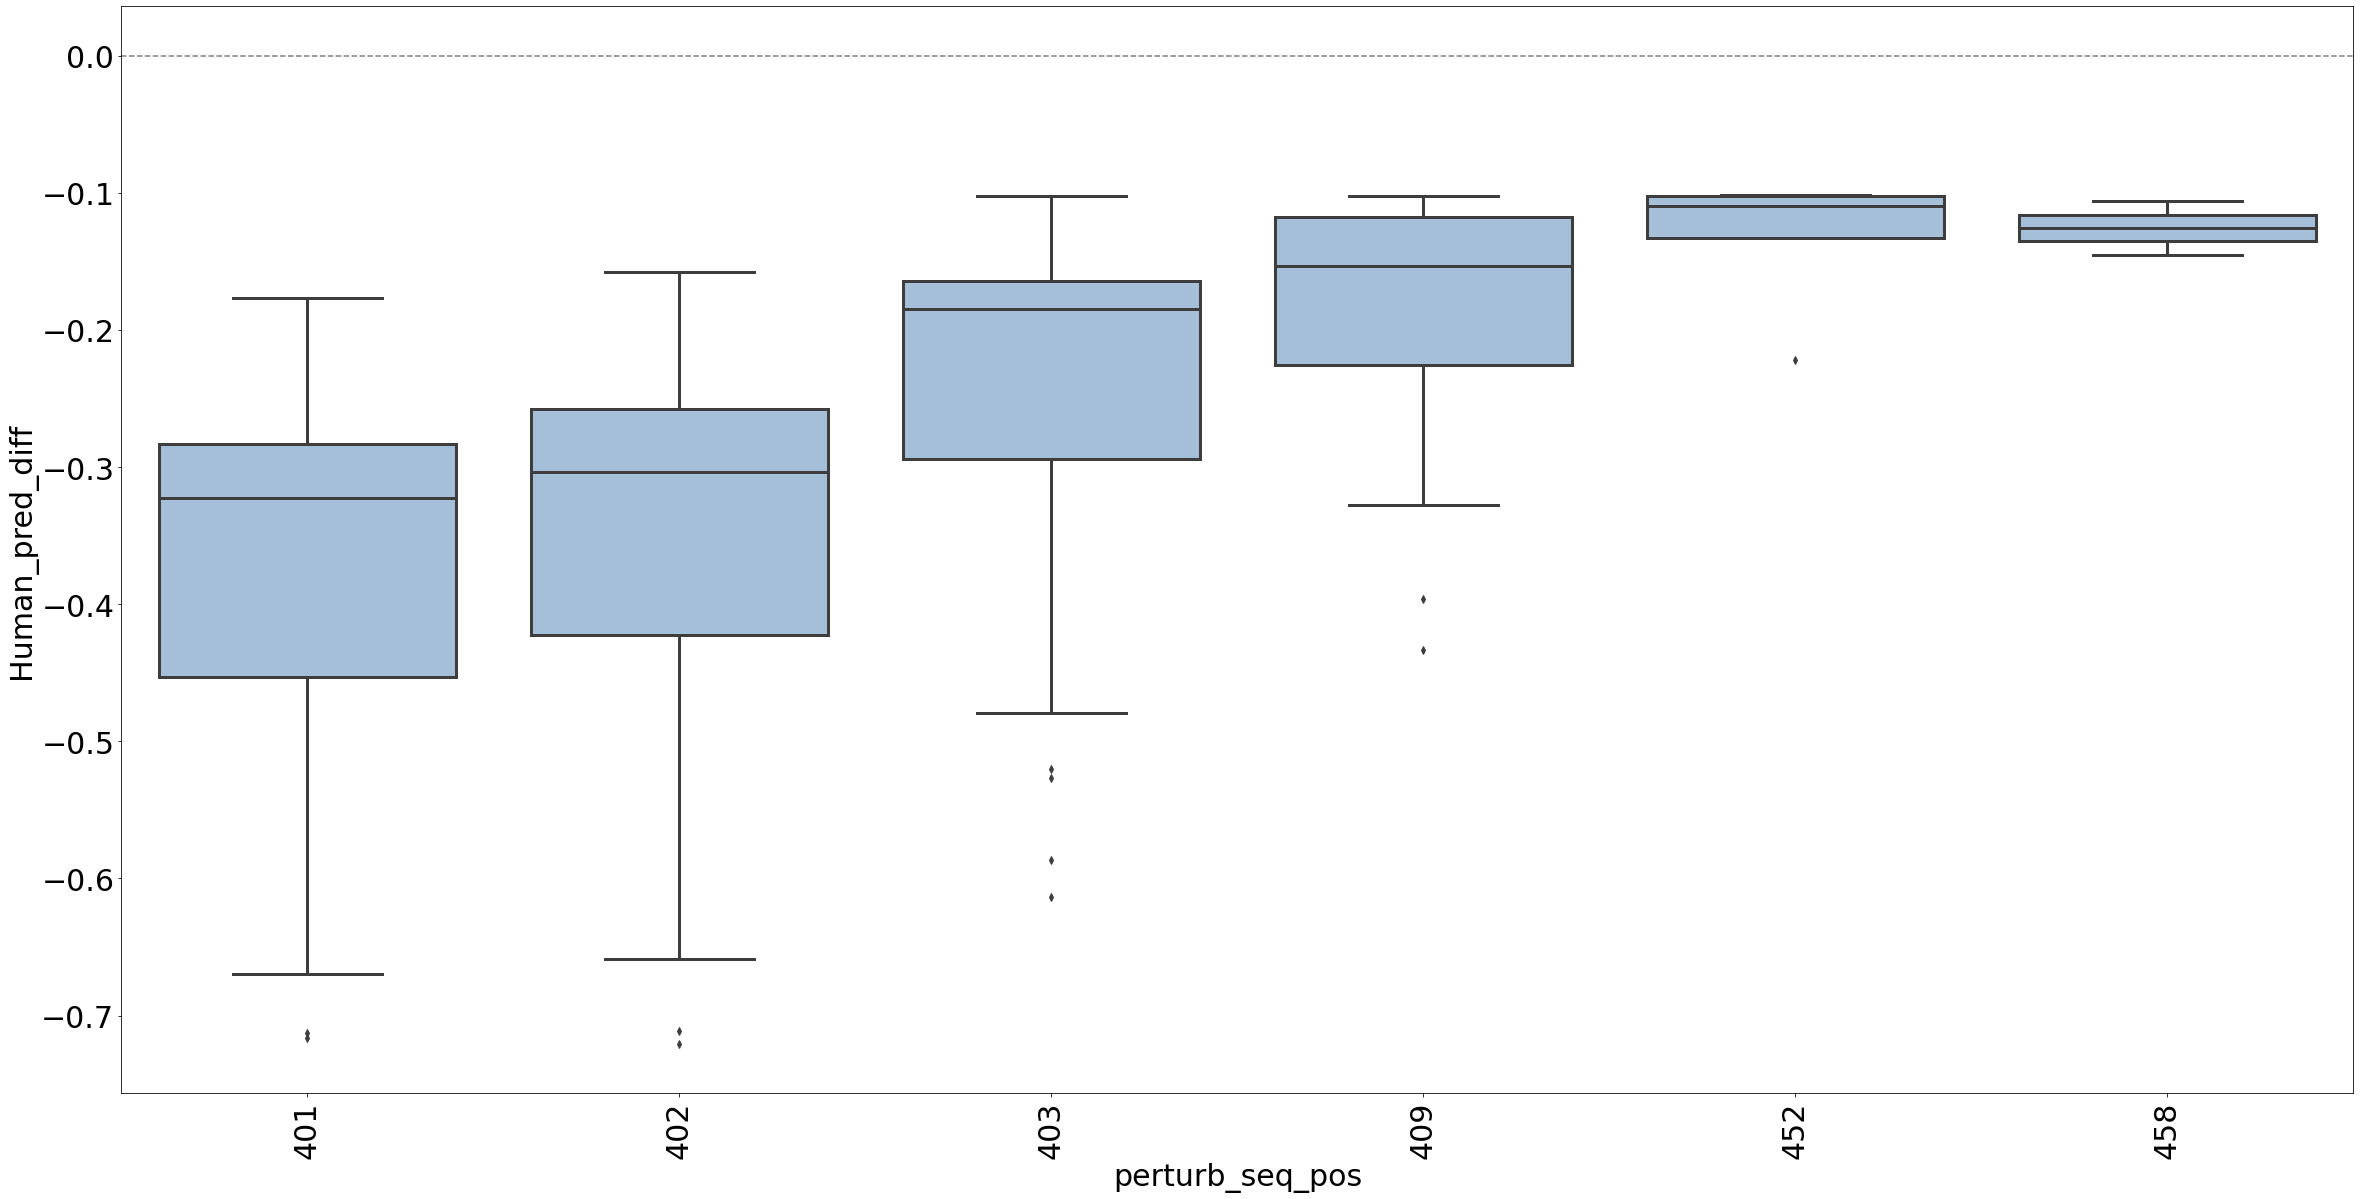

In [41]:
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

sns.boxplot(data=cut_off_df_2,  y="Human_pred_diff", x="perturb_seq_pos", ax=axs, orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs.tick_params(axis='x', rotation=90)
axs.axhline(0.0, color="gray", linestyle="--")

plt.show()


### Important positions causing class change from Human

40
47.5


<Figure size 432x288 with 0 Axes>

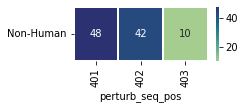

In [53]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(3, 1), sharey=True)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.heatmap(data=df.set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", annot=True, ax=axs, vmax=max_val)
wrap_yticklabels(axs, label_width=10, break_long_words=True)
axs.tick_params(axis='x', rotation=90)

# sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
# wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
# axs[1].tick_params(axis='x', rotation=90)
# plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

40


<Figure size 432x288 with 0 Axes>

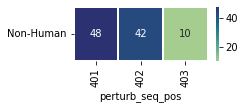

In [55]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(3, 1))
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest", annot=True)
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [56]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_189728/3113693862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


In [58]:
#!pip install textalloc

(0, 13)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No non overlapping boxes found


<Figure size 432x288 with 0 Axes>

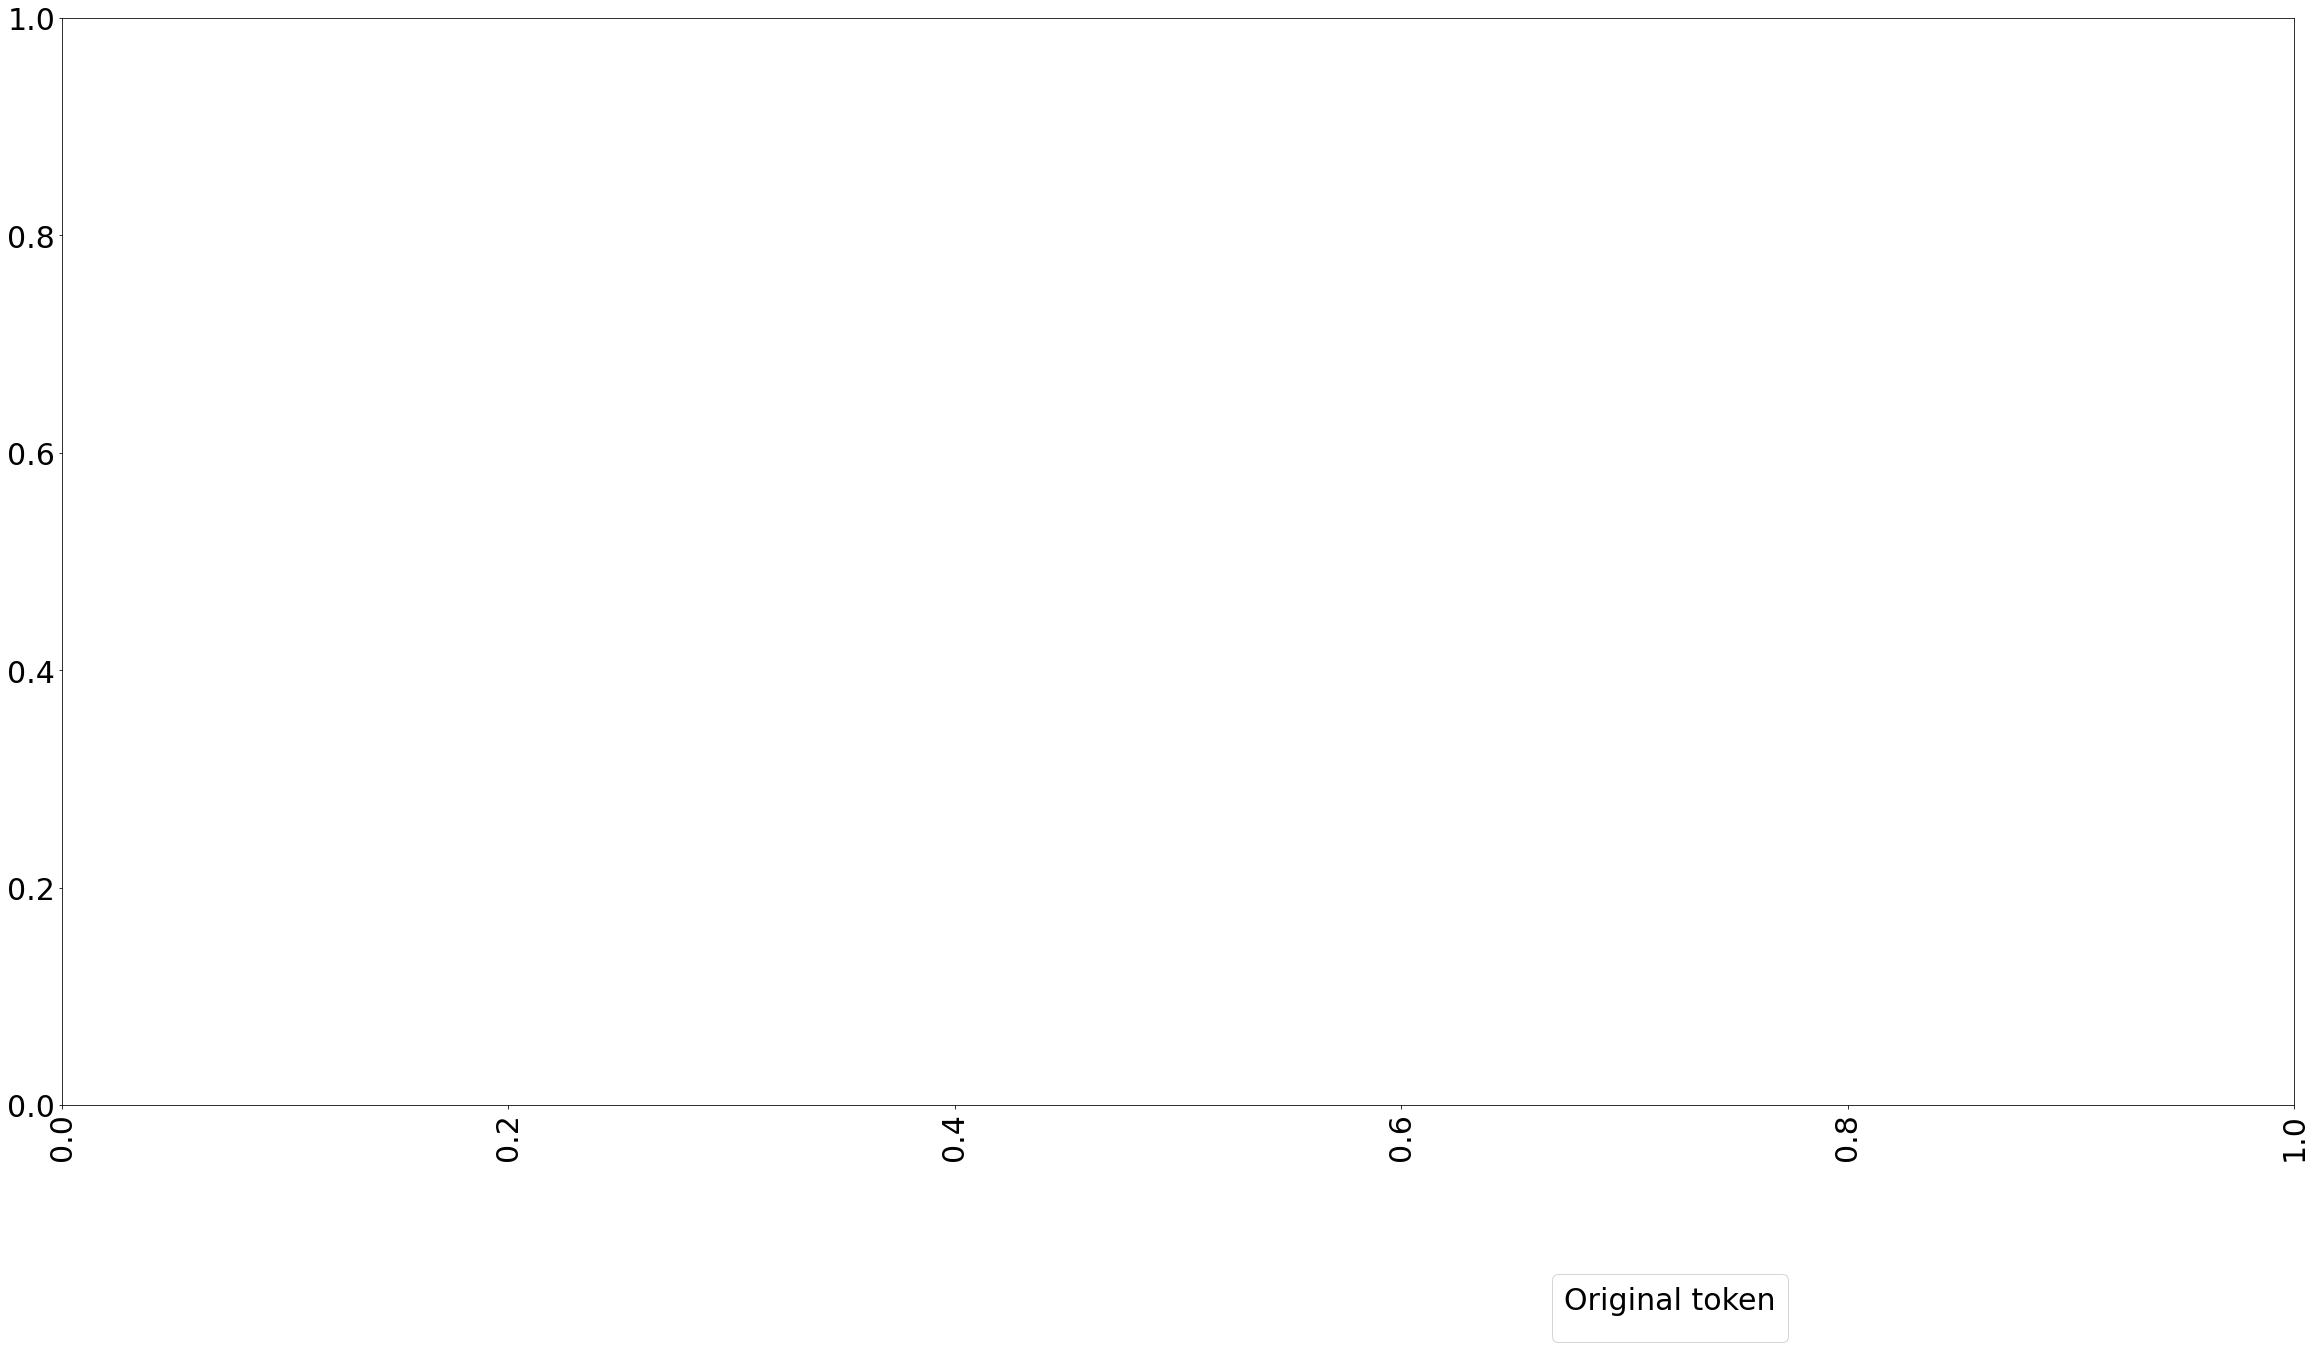

In [57]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [59]:
annotate_df

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos,perturbation_id


### Mutations with new token NOT = X

In [60]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (301, 13)
Number of unique mutations = 6


<Figure size 432x288 with 0 Axes>

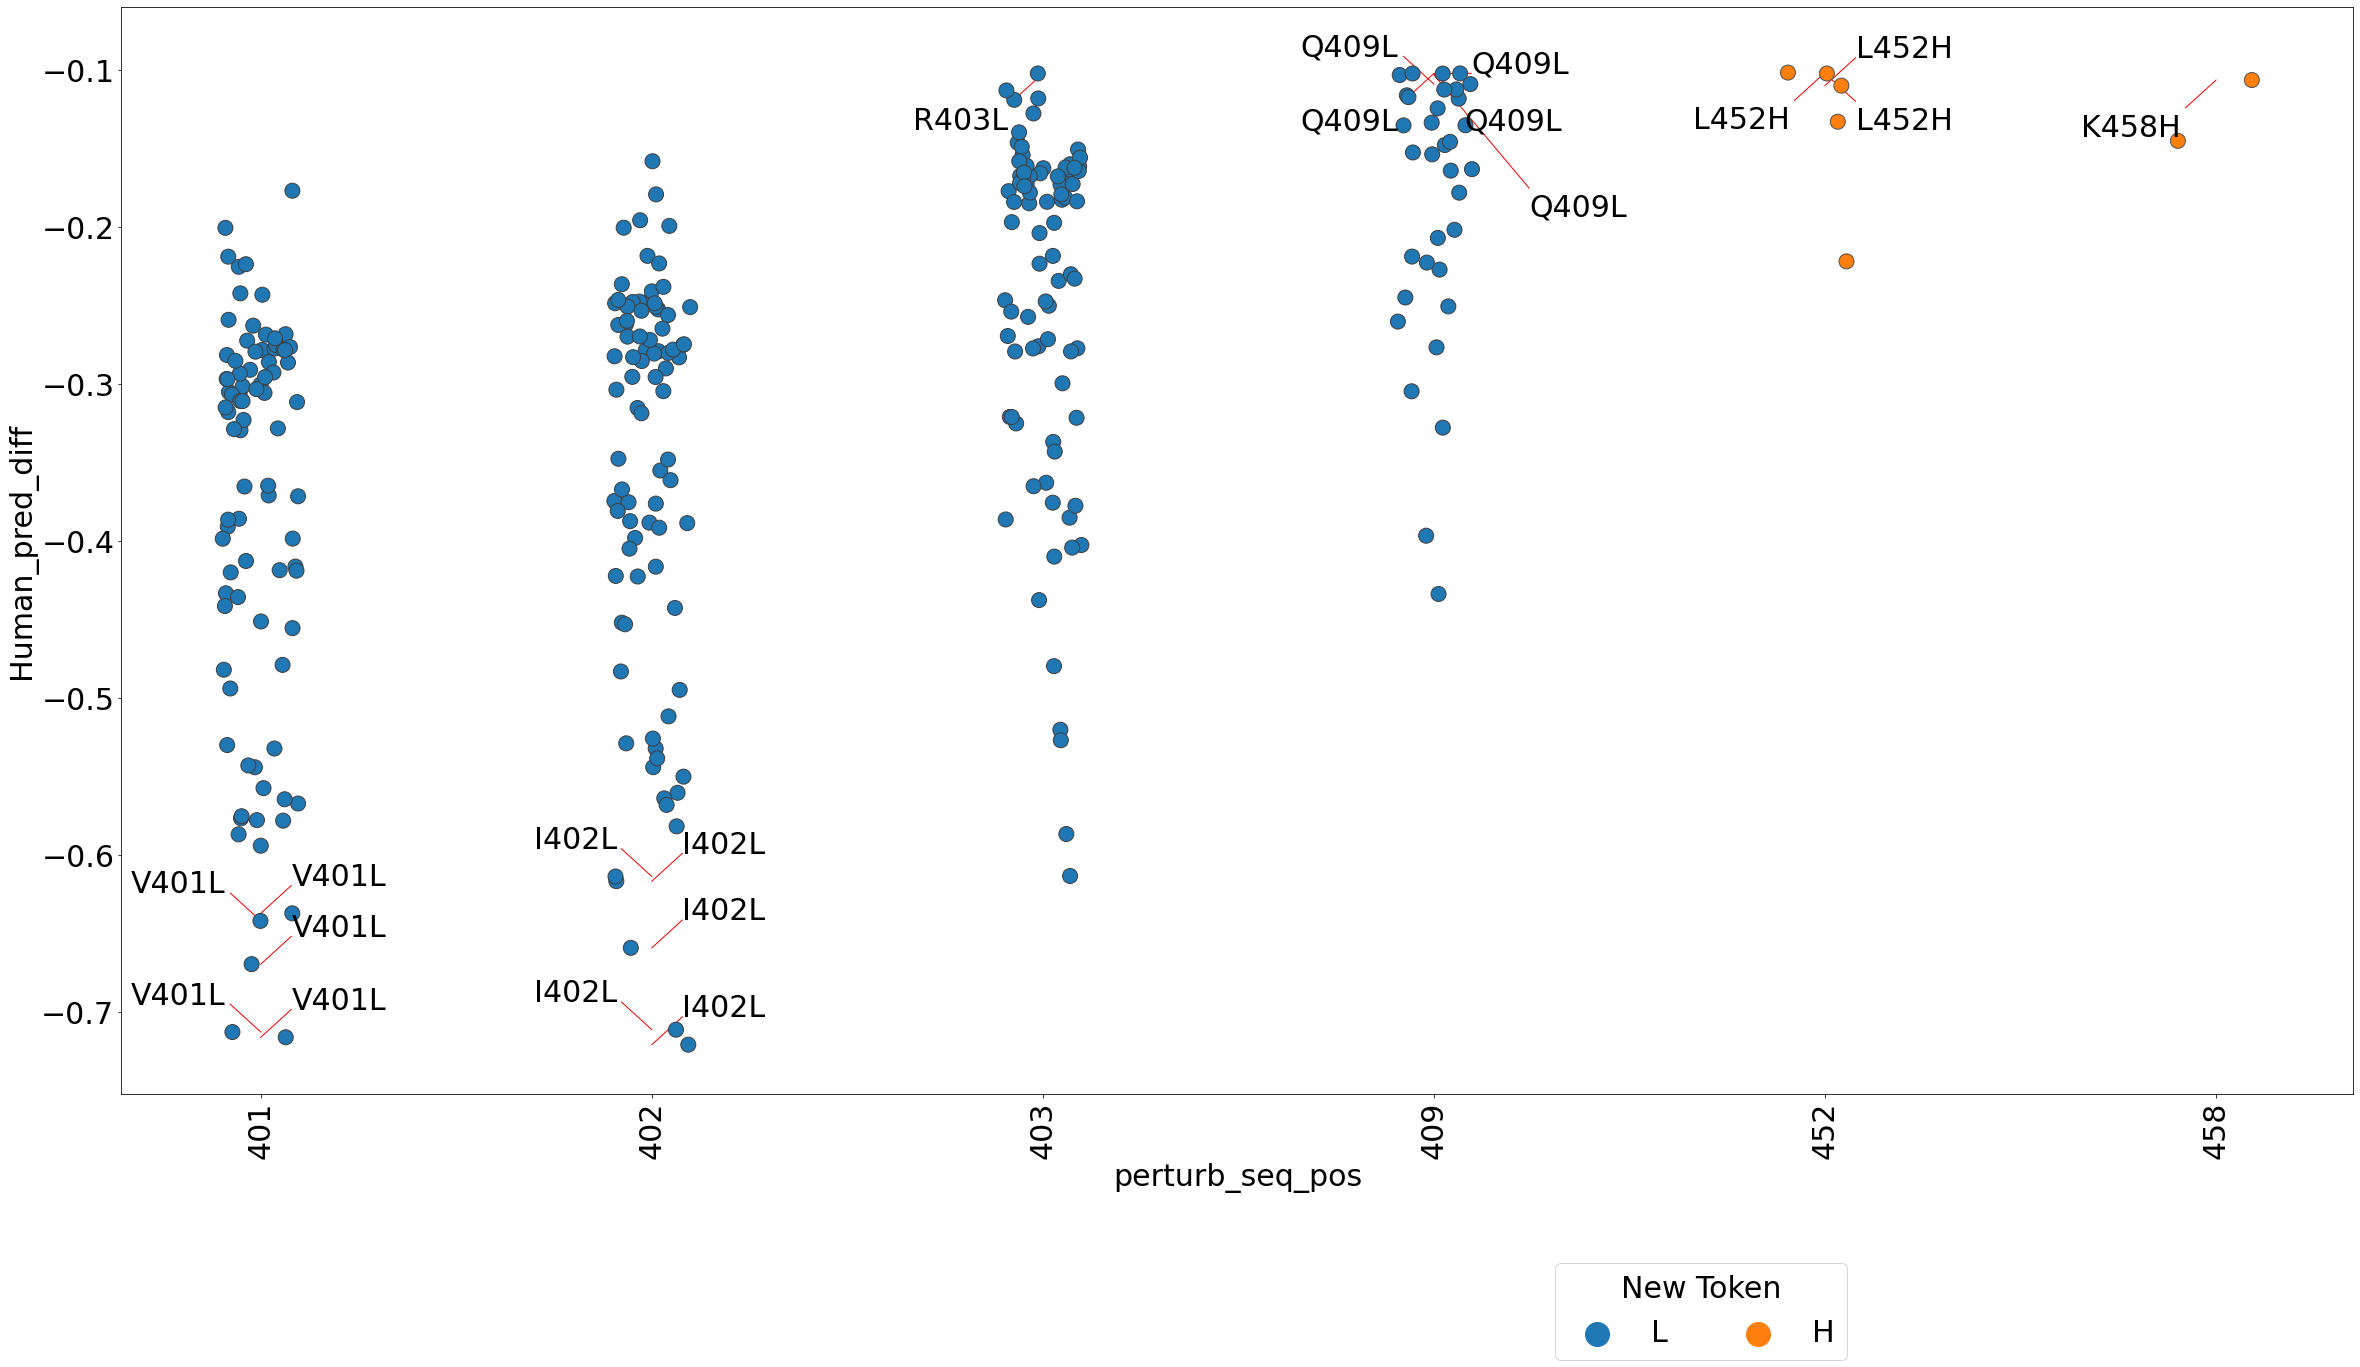

In [61]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [62]:
cut_off_df_2["perturbation_id"].nunique()

6

<Figure size 432x288 with 0 Axes>

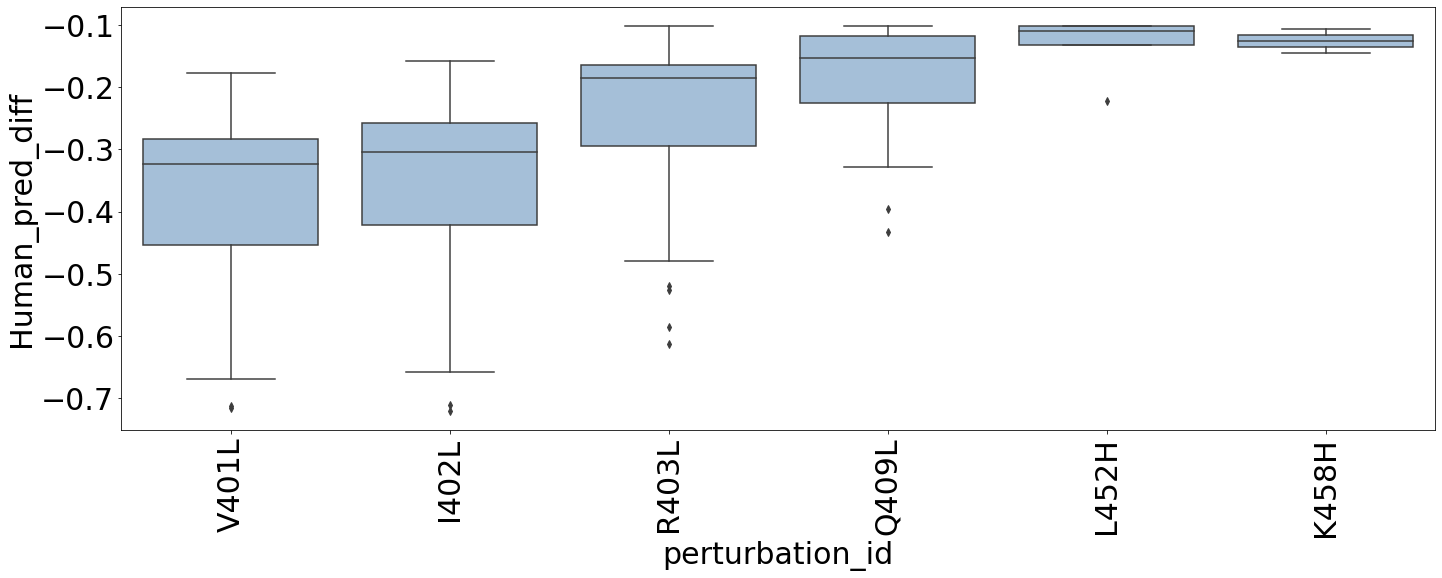

In [69]:
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(20, 8), sharex=False, sharey=True)

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()

sns.boxplot(cut_off_df_2, x="perturbation_id", y=pred_diff_col, ax=axs, orient="v", order=perturbation_ids,
           boxprops={"facecolor": (.3, .5, .7, .5)})
axs.tick_params(axis='x', rotation=90)


plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [71]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","..", "input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,orig_token,pos,new_token,perturbation_id
0,D,614,G,D614G
1,S,943,P,S943P
2,E,484,K,E484K
3,N,501,Y,N501Y
4,L,452,R,L452R
5,Q,677,P,Q677P
6,Q,677,H,Q677H
7,P,681,H,P681H
8,E,484,Q,E484Q
9,K,417,N,K417N


In [72]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

/tmp/ipykernel_189728/742767506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


In [73]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

,orig_token,pos,new_token,perturbation_id,label
0,D,614,G,D614G,D614G (n=2 | 2.13%)
1,S,943,P,S943P,S943P (n=93 | 98.94%)
2,E,484,K,E484K,E484K (n=83 | 88.30%)
3,N,501,Y,N501Y,N501Y (n=85 | 90.43%)
4,L,452,R,L452R,L452R (n=30 | 31.91%)
5,Q,677,P,Q677P,Q677P (n=88 | 93.62%)
6,Q,677,H,Q677H,Q677H (n=88 | 93.62%)
7,P,681,H,P681H,P681H (n=91 | 96.81%)
8,E,484,Q,E484Q,E484Q (n=83 | 88.30%)
9,K,417,N,K417N,K417N (n=89 | 94.68%)


<Figure size 432x288 with 0 Axes>

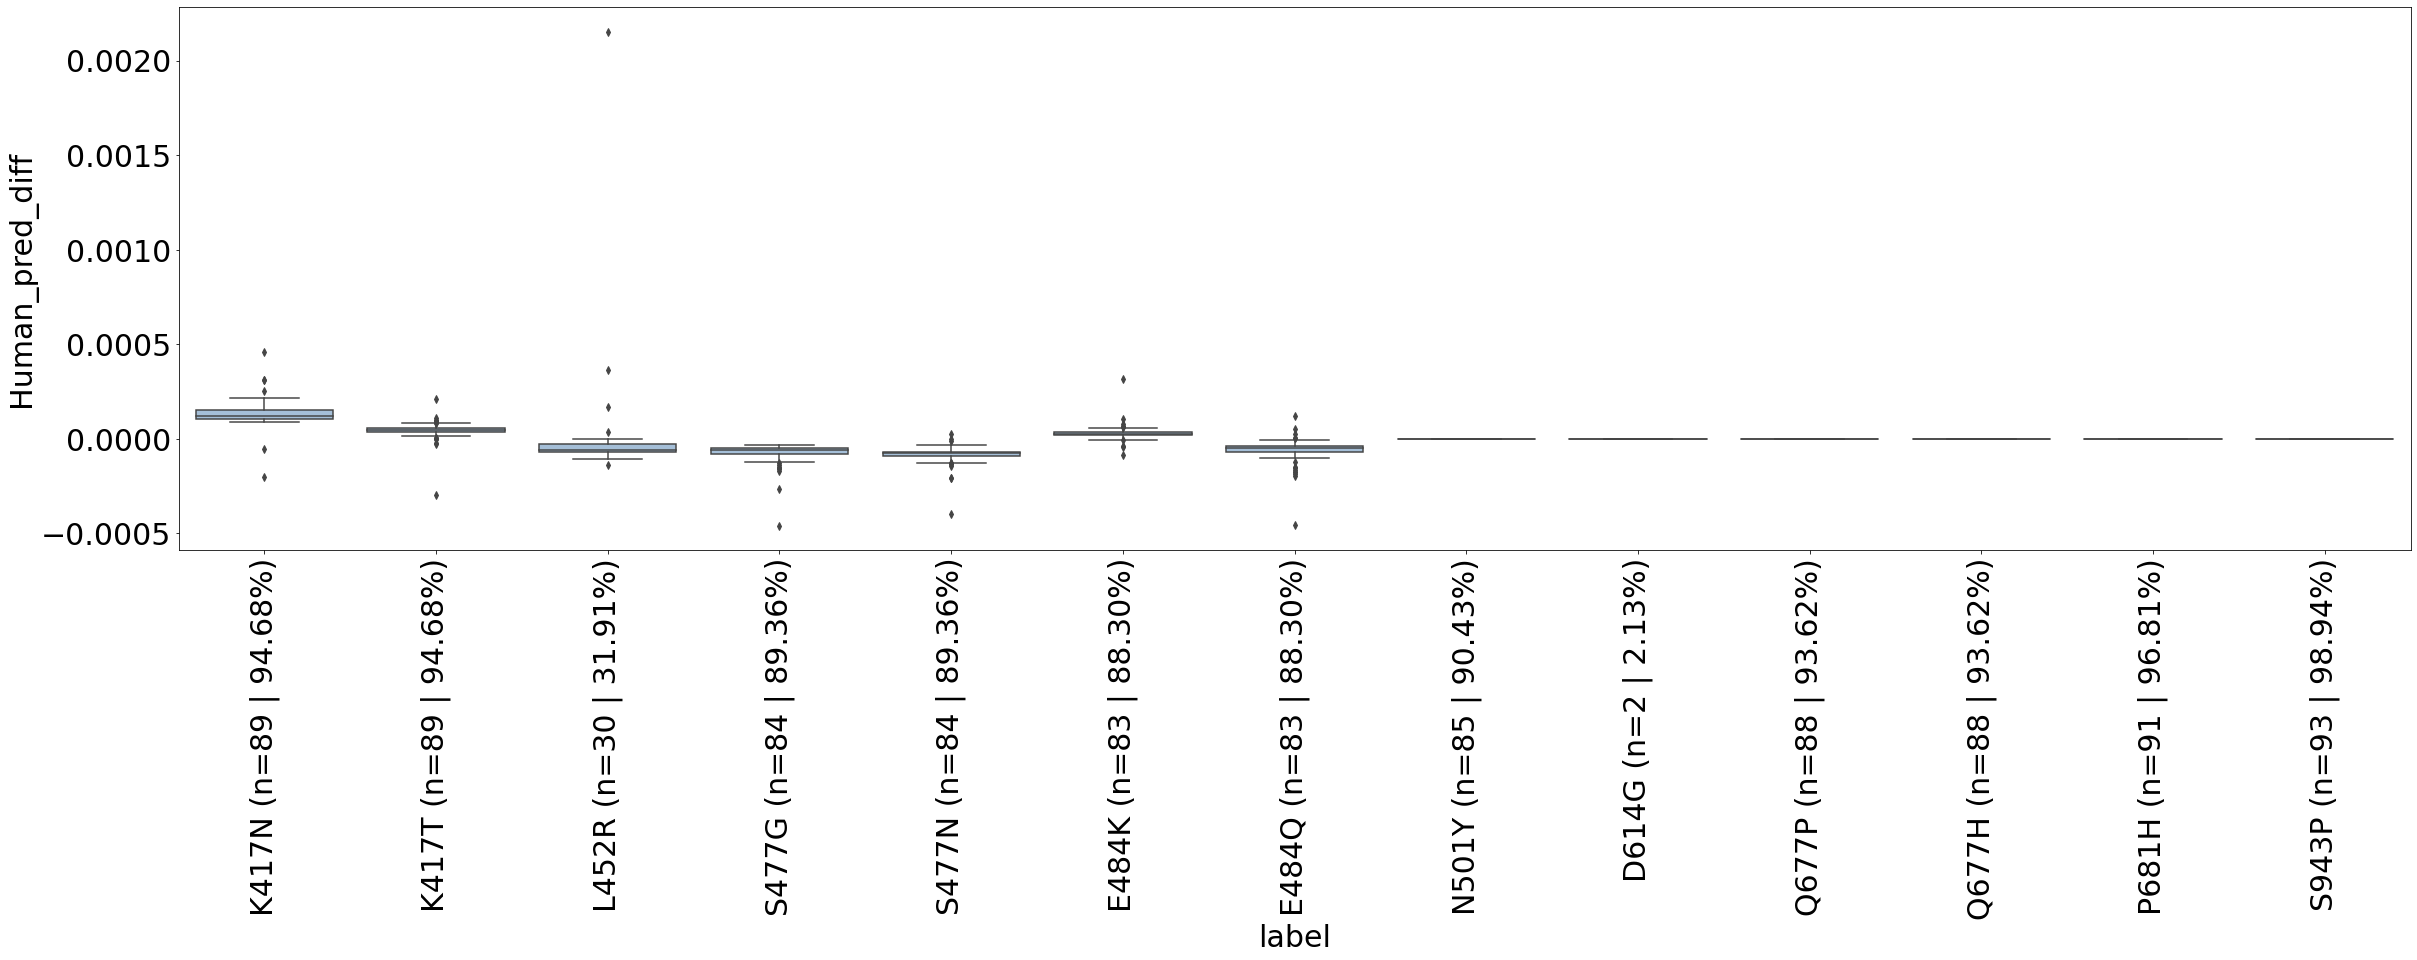

In [74]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [75]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 6
known_mutations = 13
intersection = set()


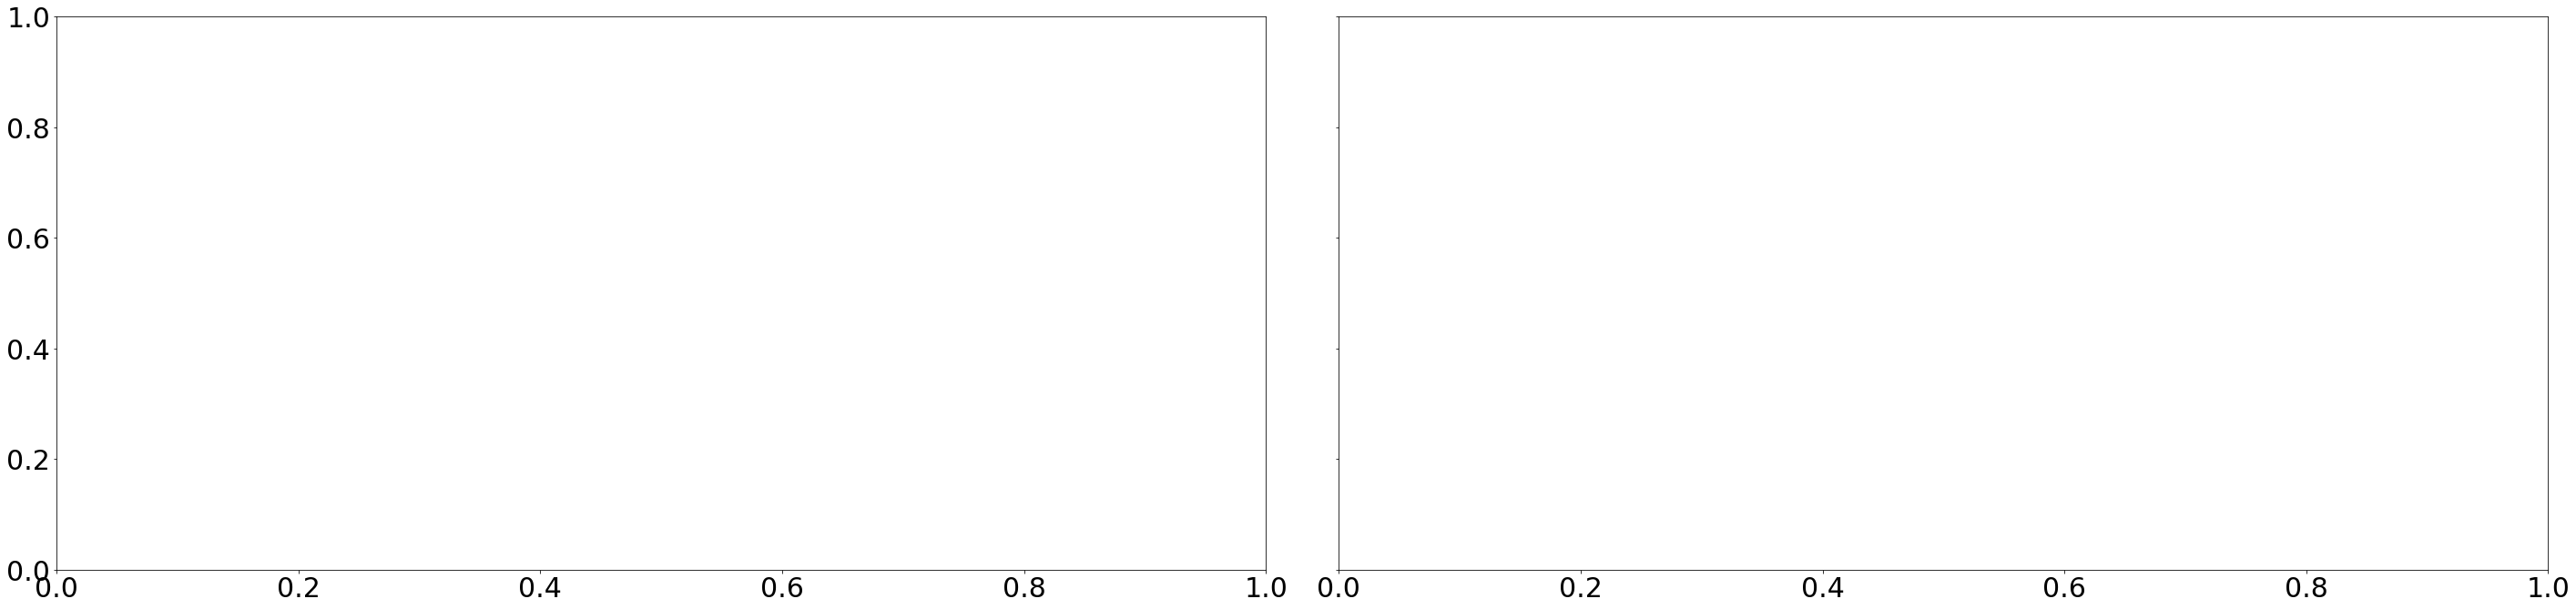

In [76]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()